In [ ]:
from matplotlib import pyplot as plt
from torch.distributions import Normal
import math
import numpy as np
import torch
import random
from tqdm import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Continuous GFlowNets on a Simple 1D Line Environment [With Solutions]

Joseph Viviano & Kolya Malkin

In this tutorial, we will explore a simple use-case of continuous GFlowNets: sampling from a distribution defined by a mixture of Gaussians. This is an exceedingly simple example which is not representative of the complexities inherent with applying this method in real applications, but will highlight some common challenges and useful tricks.

First, **please run the cell below to define some helper functions and default hyperparameters:**

In [ ]:
# @title
def seed_all(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)


def render(reward, trajectory=None):
    """Renders the reward distribution over the 1D env."""
    x = np.linspace(
        min(reward.mus) - reward.n_sd * max(reward.sigmas),
        max(reward.mus) + reward.n_sd * max(reward.sigmas),
        1000,
    )

    d = torch.exp(reward.log_reward(torch.tensor(x)))
    dual_plot = not isinstance(trajectory, type(None))

    if dual_plot:
        fig, axs = plt.subplots(2, 1)
        axs = axs.ravel()
    else:
        fig, axs = plt.subplots(1, 1)
        axs = [axs]  # Hack to allow indexing.

    if dual_plot:
        ax_dual = axs[0].twinx()  # Second axes for final state counts.
        ax_dual.hist(
            trajectory[:, -1, 0].cpu().numpy(),  # Final X Position.
            bins=100,
            density=False,
            alpha=0.5,
            color="red",
        )
        ax_dual.set_ylabel("Samples", color="red")
        ax_dual.tick_params(axis="y", labelcolor="red")

        n, trajectory_length, _ = trajectory.shape
        for i in range(n):
            axs[1].plot(
                trajectory[i, :, 0].cpu().numpy(),
                np.arange(1, trajectory_length + 1),
                alpha=0.1,
                linewidth=0.05,
                color='black',
            )
            axs[1].set_ylabel('Step')

    axs[0].plot(x, d, color="black")

    # Adds the modes.
    for mu in reward.mus:
        axs[0].axvline(mu, color="grey", linestyle="--")

    # S0
    axs[0].plot([reward.init_value], [0], 'ro')
    axs[0].text(reward.init_value + 0.1, 0.01, "$S_0$", rotation=45)

    # Means
    for i, mu in enumerate(reward.mus):
        idx = abs(x - mu.numpy()) == min(abs(x - mu.numpy()))
        axs[0].plot([x[idx]], [d[idx]], 'bo')
        axs[0].text(x[idx] + 0.1, d[idx], "Mode {}".format(i + 1), rotation=0)

    axs[0].spines[['right', 'top']].set_visible(False)
    axs[0].set_ylabel("Reward Value")
    axs[0].set_title("Line Environment")
    axs[0].set_ylim(0, max(d) * 1.1)

    if dual_plot:
        axs[1].set_xlim(axs[0].get_xlim())
        axs[1].set_xlabel("X Position")
    else:
        axs[0].set_xlabel("X Position")

    fig.tight_layout()
    plt.show()


# Set up some fixed hyperparameters for the upcoming experiments
# (until we need to change them).
trajectory_length = 5
min_policy_std = 0.1
max_policy_std = 1.0
batch_size = 256
seed = 4444

print("Beginning with the following hyperparameters:")
print("    trajectory_length: {}".format(trajectory_length))
print("    min_policy_std: {}".format(min_policy_std))
print("    max_policy_std: {}".format(max_policy_std))
print("    batch_size: {}".format(batch_size))
print("    seed: {}".format(seed))

Beginning with the following hyperparameters:
    trajectory_length: 5
    min_policy_std: 0.1
    max_policy_std: 1.0
    batch_size: 256
    seed: 4444


Our task is simple: from an initial starting point on the number line, we want to sample a set of increments such that we ultimately sample from some reward distribution, defined as a mixture of Gaussians. Each increment (or step) will be sampled from Gaussians distributions as well.

Continuous GFlowNets sample some real number(s) in a continuous space, in contrast to Discrete GFlowNets which sample discrete actions. Typically, this means your Continuous GFlowNet will use a function approximator $f(\cdot)$, which accepts the current state $s_{t}$, to predict the *paramaters of a distribution* $\rho = \{p_1, p_2, ..., p_n\}$, i.e. $\rho = f(s_t)$.

Then your chosen distribution(s) $D(\rho)$ is used to sample a real-valued tensor $x \sim D(\rho)$ which is added to your current state to produce a the next step in the state space. This sampled $x$ can be used in many ways to compute the next state, for example, $s_{t+1} = x$; $s_{t+1} = s_{t} + x$; $s_{t+1} = s_{t} * x$; etc.

> Note: we no longer consider a DAG here, but rather a topological space with distinguished source and sink states.

For simplicity, we will be considering $x$ to be a *delta*, i.e., some relative change in the state. So in this example, we will be sampling $s_{\Delta} \sim D(\rho)$ and computing $s_{t+1} = s_{t} + s_{\Delta}$.

In general, both $s_{\Delta}$ and the distribution $D(\rho)$ can be as complex as you want. In practice, this complexity can be tricky to handle and adds ample room for bugs, so these elements should be as simple as feasible for your problem. To get you started, we're going to work with $s_{\Delta}$ being a single scalar, and $D(\rho)$ being a simple Gaussian distribution. At the end, we will point to resources covering more complex settings which involve sampling from mixtures of distributions in $n$-dimensional spaces, which is more representative of common Continuous GFlowNet use-cases.

# Defining the Environment

First let's define our environment. We require a few things. First, we need a reward distribution. This will be a mixture of Gaussians on the real number line, each defined by a $\mu$ and $\sigma$. Recall the formula of a Gaussian:

$$g(x) = \frac{1}{\sigma\sqrt{2\pi}} exp \big(-\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2} \big)$$

The reward at each point will simply be the sum of the PDFs at that point across all elements of the mixture. We also define an arbitrary source state $S_0$ (where all trajectories will start) as `init_value`.

The GFlowNet must sample increments along the number line such that it samples final values along the number line proportionally to the mixture distribution.



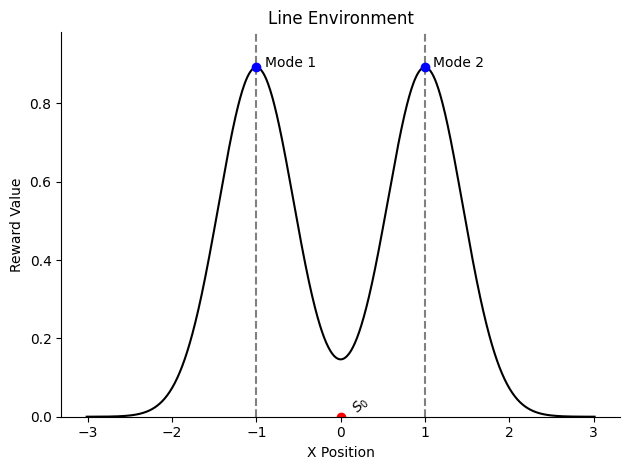

In [ ]:
class LineEnvironment():
    def __init__(self, mus, variances, n_sd, init_value):
        self.mus = torch.tensor(mus)
        self.sigmas = torch.tensor([math.sqrt(v) for v in variances])
        self.variances = torch.tensor(variances)
        self.mixture = [
            Normal(m, s) for m, s in zip(self.mus, self.sigmas)
        ]

        self.n_sd = n_sd
        self.lb = min(self.mus) - self.n_sd * max(self.sigmas)  # Convienience only.
        self.ub = max(self.mus) + self.n_sd * max(self.sigmas)  # Convienience only.

        self.init_value = init_value  # Used for s0.
        assert self.lb < self.init_value < self.ub

    def log_reward(self, x):
        """Log of the sum of the exponential of each log probability in the mixture."""
        return torch.logsumexp(torch.stack([m.log_prob(x) for m in self.mixture], 0), 0)

    @property
    def log_partition(self) -> float:
        """Log Partition is the log of the number of gaussians."""
        return torch.tensor(len(self.mus)).log()


env = LineEnvironment(mus=[-1, 1], variances=[0.2, 0.2], n_sd=4.5, init_value=0)
render(env)

# Policies, Actions, and States

Next, we need a distribution from which to sample these steps. To parameterize this, we will need a neural network to predict the parameters of the Gaussian: $\mu$, the mean, and $\sigma$, the standard deviation. We're also going to enforce that $ 0.1 <= \sigma <= 1$ to help with convergence (see the hyperparameters above).

Recall that in order to act in our environment, we have to do two things. First, we need to use a function approximator to predict the parameters of a distribution, then to sample from that distribution to produce the actions. Here, we have a neural network that outputs $\mu$ and $\sigma$ of the normal distribution, with the constraint that `min_policy_std <=` $\sigma$ `<= max_policy_std`. Our policy is then this distribution object we can sample from:

In [ ]:
def get_policy_dist(model, x):
    """
    A policy is a distribution we predict the parameters of using a neural network,
    which we then sample from.
    """
    pf_params = model(x)  # Shape = [batch_shape, 2].
    policy_mean = pf_params[:, 0]
    policy_std = torch.sigmoid(pf_params[:, 1]) * (max_policy_std - min_policy_std) + min_policy_std
    policy_dist = torch.distributions.Normal(policy_mean, policy_std)

    return policy_dist

## Why Our State Must Include A Counter

We need to ensure there are no cycles in our state space to follow the theory of GFlowNets, but in this set up, a cycle would be easy to obtain. If we sampled first an increment of $+1$ and then an increment of $-1$, we could produce a cycle, and there are an infinite number of these on the real number line. To prevent cycles, let's simply include the count value, $t$, in the state $s_t$. In this setup, the state vector is `[x_position, n_steps]`, and the previous trajectory $[0, 0] \rightarrow [1, 1] \rightarrow [0, 2]$ would not be considerd a cycle. This step counter also can be used to know when to terminate this process, otherwise we never sample a final value. In this case, let's always terminate when $t=5$ (see hyperparameters above). There are more sophisitcated ways to handle termination, but they add complexity, and we want to focus this tutorial on only the core concepts.

## Applying Actions to States

For each forward action, we will add the action value to the current state, and increment the step counter. A backward action is simply the inverse: we will substract the action value from the current state, and decrement the *step* counter.

Given this distribution we retrieve from `get_policy_dist()`, we sample an action $s_{\Delta} \sim D(\rho)$. Recall that our state representation is `(x_position, n_steps)`. In this case, we are sampling $x_{\Delta} \sim \mathcal{N}(\mu, \sigma^2)$, and our next state is `(x_position + x_delta, n_steps + 1)`.

We'll also define a function that initalizes a state at $S_0$, which in our case has the `x_position` set to whatever we defined in our environment, and `n_steps` to 0.

In [ ]:
def step(x, action):
    """Takes a forward step in the environment."""
    new_x = torch.zeros_like(x)
    new_x[:, 0] = x[:, 0] + action  # TODO: Complete - add action delta.
    new_x[:, 1] = x[:, 1] + 1  # TODO: Complete - increment step counter.

    return new_x


def initalize_state(batch_size, device, env, randn=False):
    """Trajectory starts at state = (X_0, t=0)."""
    x = torch.zeros((batch_size, 2), device=device)
    x[:, 0] = env.init_value  # TODO: Complete.

    return x

# Model Definition, Training Loop, and Loss

Below is a simple training loop. We're going to use Trajectory Balance (TB) for this demo. Recall the TB loss:

$$L(\tau) = \left(\log Z_{\theta} + \sum_t \log P_F(s_{t+1}|s_t;\theta) - \log R(x) - \sum_t \log P_B(s_t|s_{t+1}; \theta) \right)^2$$

so we need a forward model to generate trajectories $\tau$ and calculate $P_F$, we need a backward model to calculate $P_F$, and we need an estimate of logZ $\log Z_{\theta}$, along with an optimizer.

Let's set those up first. We'll parameterize both the `forward_model` and the `backward_model` as two small neural networks, each taking in the state `[x_position, n_steps]` and outputting the parameters of a Normal distribution `[mean, standard_deviation]`. The `logZ` estimate is a scalar parameter.

> Note a common optimization trick for TB here, where the learning rate of `logZ` is faster than the other networks.

These models will be used to predict the parameters of the policies themselves.

In [ ]:
def setup_experiment(hid_dim=64, lr_model=1e-3, lr_logz=1e-1):
    """Generate the learned parameters and optimizer for an experiment.

    Forward and backward models are MLPs with a single hidden layer. logZ is
    a single parameter. Note that we give logZ a higher learning rate, which is
    a common trick used when utilizing Trajectory Balance.
    """
    # Input = [x_position, n_steps], Output = [mus, standard_deviations].
    forward_model = torch.nn.Sequential(torch.nn.Linear(2, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, 2)).to(device)

    backward_model = torch.nn.Sequential(torch.nn.Linear(2, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, 2)).to(device)

    logZ = torch.nn.Parameter(torch.tensor(0.0, device=device))

    optimizer = torch.optim.Adam(
        [
            {'params': forward_model.parameters(), 'lr': lr_model},
            {'params': backward_model.parameters(), 'lr': lr_model},
            {'params': [logZ], 'lr': lr_logz},
        ]
    )

    return (forward_model, backward_model, logZ, optimizer)

Finally, our training loop, which is greatly simplified due to the use of fixed-length trajectories (defined  as `trajectory_length` steps - currently set to 5). With probabilisitc exit actions, the logic becomes more tricky, though it is often useful.

In our forward loop through the trajectory, we use our `forward_model` to calculate the `forward_policy`, sample an `action` from that policy, and finally calculate the log probability of that action an add it to `logPF`, which records the sum of the log probabilities (i.e., the product of the conditional probabilities, which is the probability of the trajectory). We store each new state in the trajectory.

For the backward loop, we sample the parameters of a `backward_policy` from the `backward_model`, and evaluate the log probability of the observed action (`trajectory[:, t, 0] - trajectory[:, t - 1, 0]`) under this policy. The trajectory dimensions are `[batch_dim, trajectory_step, state]`. We use this to calculate the probability of the backward trajectory by accumulating the sum of `logPB`. Note that the `n_step` counter is only part of the state, not the action, so we can remove it when indexing on the `state` dimension.

We finally calculate the `log_reward` from the terminal states under our environment reward, and calculate the trajectory balance loss, which we use to update the parameters of the `forward_model`, `backward_model`, and `logZ`.

This should only take a few minutes to train:

In [ ]:
def train(seed, batch_size, trajectory_length, env, device, n_iterations):
    """Continuous GFlowNet training loop, with the Trajectory Balance objective."""
    seed_all(seed)
    forward_model, backward_model, logZ, optimizer = setup_experiment()  # Default hyperparameters used.
    losses = []
    tbar = trange(n_iterations)
    true_logZ = env.log_partition

    for it in tbar:
        optimizer.zero_grad()

        x = initalize_state(batch_size, device, env)

        # Trajectory stores all of the states in the forward loop.
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        logPF = torch.zeros((batch_size,), device=device)
        logPB = torch.zeros((batch_size,), device=device)

        # Forward loop to generate full trajectory and compute logPF.
        for t in range(trajectory_length):
            policy_dist = get_policy_dist(forward_model, x)  # TODO: Fill in the blank here.
            action = policy_dist.sample()  # TODO: Fill in the blank here.
            logPF += policy_dist.log_prob(action)  # TODO: Fill in the blank here.

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

        # Backward loop to compute logPB from existing trajectory under the backward policy.
        for t in range(trajectory_length, 0, -1):
            policy_dist = get_policy_dist(backward_model, trajectory[:, t, :])  # TODO: Fill in the blank here.
            action = trajectory[:, t, 0] - trajectory[:, t - 1, 0]  # TODO: Fill in the blank here.
            logPB += policy_dist.log_prob(action)  # TODO: Fill in the blank here.

        log_reward = env.log_reward(trajectory[:, -1, 0])  # Reward from the final state.  # TODO: Fill in the blank here.

        # Compute Trajectory Balance Loss.
        loss = (logZ + logPF - logPB - log_reward).pow(2).mean()  # TODO: Fill in the blank here.
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if it % 100 == 0:
            tbar.set_description("Training iter {}: (loss={:.3f}, estimated logZ={:.3f}, true logZ={:.3f}, LR={}".format(
                it,
                np.array(losses[-100:]).mean(),
                logZ.item(),
                true_logZ,
                optimizer.param_groups[0]['lr'],
                )
            )

    return (forward_model, backward_model, logZ)

n_iterations = 5000
forward_model, backward_model, logZ = train(seed, batch_size, trajectory_length, env, device, n_iterations)

Training iter 4900: (loss=0.019, estimated logZ=-1.884, true logZ=0.693, LR=0.001: 100%|██████████| 5000/5000 [01:30<00:00, 55.29it/s]


Next, we can view the behaviour of our GFlowNet by sampling new trajectories under fixed models. We'll plot two things. On top, we'll see the distribution of the final samples from each trajectory, alongside the original reward distribution. Underneath it, we'll show the `x_position` values at each step along the full trajectory. Note that at inference time, we only need the `forward_model`.

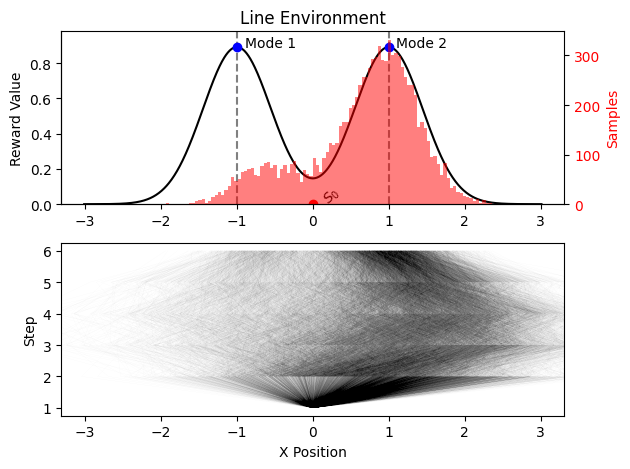

In [ ]:
def inference(trajectory_length, forward_model, env, batch_size=10_000):
    """Sample some trajectories."""

    with torch.no_grad():
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        trajectory[:, 0, 0] = env.init_value

        x = initalize_state(batch_size, device, env)

        for t in range(trajectory_length):
            policy_dist = get_policy_dist(forward_model, x)
            action = policy_dist.sample()

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

    return trajectory

trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

# Careful With that logPB, Eugene

Yeesh! That doesn't look good. What happened? Recall that for the Trajectory Balance loss, we must match $P_F$ and $P_B$. When we sample our forward trajectory $\tau_F = S_0 \rightarrow S_1 \rightarrow S_2 \rightarrow \cdots \rightarrow S_4 \rightarrow S_5$, we can accumulate the log probability of each transition under the gaussian distribution parameterized by our model. For the backward trajectory, $\tau_B = S_5 \rightarrow S_4 \rightarrow \cdots S_2 \rightarrow S_1 \rightarrow S_0$, we should accumulate the log probabilities using the same strategy, **except** for the transition $S_1 \rightarrow S_0$.

Since **every state reachable by the backward policy must also be reachable by the forward policy**, we also need to enforce that the the final transition of the backward policy goes exactly to $S_0$. Currently, we're sampling this transition, and under our current parameterization, it's actually impossible to precisely sample this exact transition every time. Since we **know** the transition $S_1 \rightarrow S_0$ and that the backward trajectory must terminate at **exactly** $S_0$, we can say this transition happens with probability 1 (i.e., log probability 0). In the past implementation, we didn't do that, because our backward loop was `for t in range(trajectory_length, 0, -1)`...

Let's fix this in the code below: if we make the backward loop `t in range(trajectory_length, 1, -1),`, we'll loop over a list of trajectory indices `[trajectory_length, trajectory_length-1, ..., 2]`, and the loop itself handles the transitions between `t` and `t-1`. Therefore, we will calculate the log probabilities of the transition $S_2 \rightarrow S_1$, but not $S_1 \rightarrow S_0$. This is correct, because that final transition happens with probability 1, and we should therefore correctly always add `0` when accumulating `logPB` for this last transition.


Training iter 4900: (loss=0.080, estimated logZ=0.650, true logZ=0.693, LR=0.001: 100%|██████████| 5000/5000 [01:23<00:00, 59.74it/s]


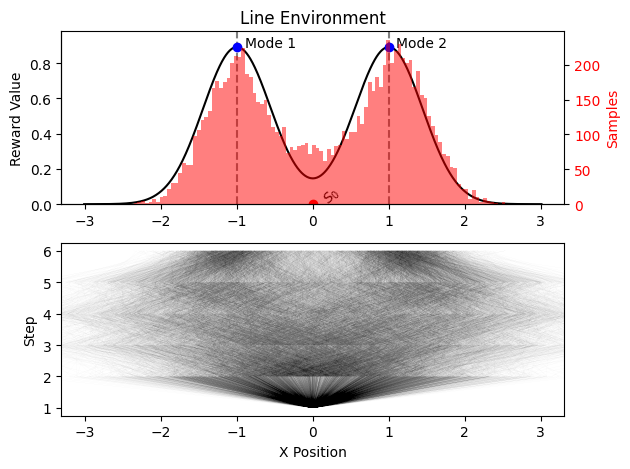

In [ ]:
def train_with_correct_PB(seed, batch_size, trajectory_length, env, device, n_iterations):
    """Continuous GFlowNet training loop, with the Trajectory Balance objective."""
    seed_all(seed)
    forward_model, backward_model, logZ, optimizer = setup_experiment()  # Default hyperparameters used.
    losses = []
    tbar = trange(n_iterations)
    true_logZ = env.log_partition

    for it in tbar:
        optimizer.zero_grad()

        x = initalize_state(batch_size, device, env)

        # Trajectory stores all of the states in the forward loop.
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        logPF = torch.zeros((batch_size,), device=device)
        logPB = torch.zeros((batch_size,), device=device)

        # Forward loop to generate full trajectory and compute logPF.
        for t in range(trajectory_length):
            policy_dist = get_policy_dist(forward_model, x)
            action = policy_dist.sample()
            logPF += policy_dist.log_prob(action)

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

        # Backward loop to compute logPB from existing trajectory under the backward policy.
        # Note this range skips S_1 -> S_0 -- we assign this action automatically p=1,
        # or log probability 0, which we don't need to explictly accumulate to logPB.
        for t in range(trajectory_length, 1, -1):  # TODO: We fixed this line!
            policy_dist = get_policy_dist(backward_model, trajectory[:, t, :])
            action = trajectory[:, t, 0] - trajectory[:, t - 1, 0]
            logPB += policy_dist.log_prob(action)

        log_reward = env.log_reward(trajectory[:, -1, 0])  # Reward from the final state.

        # Compute Trajectory Balance Loss.
        loss = (logZ + logPF - logPB - log_reward).pow(2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if it % 100 == 0:
            tbar.set_description("Training iter {}: (loss={:.3f}, estimated logZ={:.3f}, true logZ={:.3f}, LR={}".format(
                it,
                np.array(losses[-100:]).mean(),
                logZ.item(),
                true_logZ,
                optimizer.param_groups[0]['lr'],
                )
            )

    return (forward_model, backward_model, logZ)

n_iterations = 5000
forward_model, backward_model, logZ = train_with_correct_PB(seed, batch_size, trajectory_length, env, device, n_iterations)
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

# I Have Dropped Modes and I Must Scream

Well, it looks OK! Maybe not perfect (we could get there training longer), but let's move on. In this example, there's a reasonable amount of probability mass connecting the two modes of the distribution. Let's try to make the example harder by placing the modes far from $S_0$:

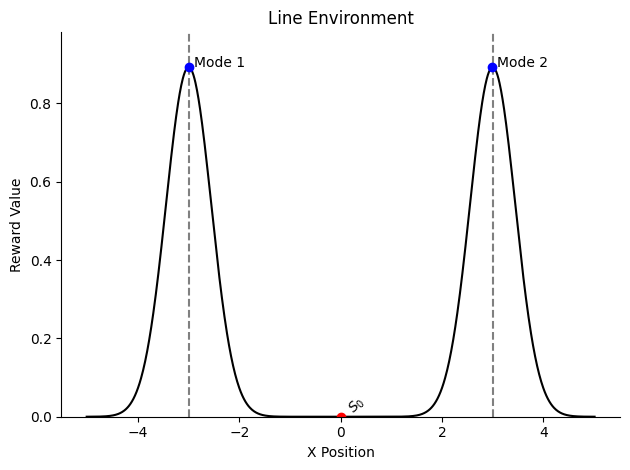

In [ ]:
env = LineEnvironment(mus=[-3, 3], variances=[0.2, 0.2], n_sd=4.5, init_value=0)
render(env)

Let's train a model using the same hyperparameters on this environment.

Training iter 4900: (loss=0.001, estimated logZ=0.000, true logZ=0.693, LR=0.001: 100%|██████████| 5000/5000 [01:23<00:00, 59.60it/s]


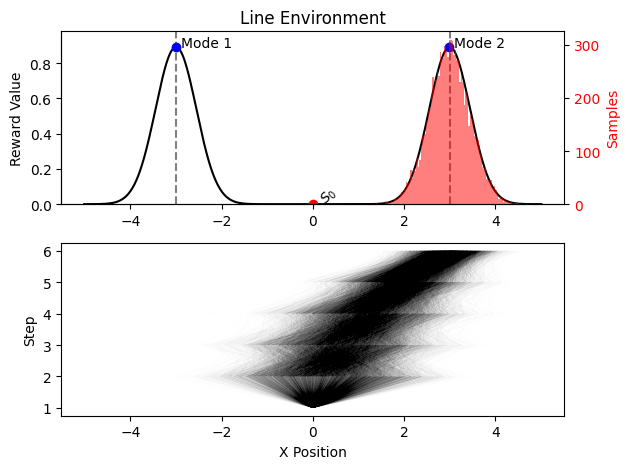

In [ ]:
n_iterations = 5000
forward_model, backward_model, logZ = train_with_correct_PB(seed, batch_size, trajectory_length, env, device, n_iterations)
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

What we're seeing here is mode collapse due to on policy training. We can fix this with off policy exploration.

# Off Policy Exploration

We can go off policy in many ways, but one simple way would be to add some constant to the variance predicted by our forward policy for the normal distribution. We can also decay this constant linearly over training iterations too facilitate convergence.

Let's define a new function that retrieves both our learned policy and off policy sampler:

In [ ]:
def get_policy_and_exploration_dist(model, x, off_policy_noise):
    """
    A policy is a distribution we predict the parameters of using a neural network,
    which we then sample from.
    """
    pf_params = model(x)
    policy_mean = pf_params[:, 0]
    policy_std = torch.sigmoid(pf_params[:, 1]) * (max_policy_std - min_policy_std) + min_policy_std
    policy_dist = torch.distributions.Normal(policy_mean, policy_std)

    # Add some off-policy exploration.
    exploration_dist = torch.distributions.Normal(policy_mean, policy_std + off_policy_noise)  # TODO: Fill in the blank here!

    return policy_dist, exploration_dist


In the below training loop, let's add the changes needed to allow for off policy exploration. To do so, we need to accomplish a few things:

1. Define a value to increase the variance by, to encourage exploration. Ideally, this would be on a schedule, i.e,, the value we are adding to the variance of the predicted distribution will decrease over iterations. Let's use the `init_explortation_noise` variable for this.
2. Sample actions from the exploration distribution.
3. Calculate `logPF` using the log probabilities of the samples action from the policy distribution.

In [ ]:
def train_with_exploration(
        seed,
        batch_size,
        trajectory_length,
        env,
        device,
        init_exploration_noise,
        n_iterations,
    ):
    """Continuous GFlowNet training loop, with expploration, and the Trajectory Balance objective."""
    seed_all(seed)
    forward_model, backward_model, logZ, optimizer = setup_experiment()   # Default hyperparameters used.
    losses = []
    tbar = trange(n_iterations)
    true_logZ = env.log_partition

    exploration_schedule = np.linspace(init_exploration_noise, 0,  n_iterations)   # TODO: Fill in the blank, optional.

    for iteration in tbar:
        optimizer.zero_grad()

        x = initalize_state(batch_size, device, env)

        # Trajectory stores all of the states in the forward loop.
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        logPF = torch.zeros((batch_size,), device=device)
        logPB = torch.zeros((batch_size,), device=device)

        # Forward loop to generate full trajectory and compute logPF.
        for t in range(trajectory_length):
            # TODO: Fill in the blanks here.
            policy_dist, exploration_dist = get_policy_and_exploration_dist(
                forward_model,
                x,
                exploration_schedule[iteration],  # TODO: Fill in the blank here.
            )
            action = exploration_dist.sample()  # TODO: Fill in the blank here.
            logPF += policy_dist.log_prob(action)  # TODO: Fill in the blank here.

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

        # Backward loop to compute logPB from existing trajectory under the backward policy.
        # Note this range skips S_1 -> S_0 -- we assign this action automatically p=1,
        # or log probability 0, which we don't need to explictly accumulate to logPB.
        for t in range(trajectory_length, 1, -1):
            policy_dist = get_policy_dist(backward_model, trajectory[:, t, :])
            action = trajectory[:, t, 0] - trajectory[:, t - 1, 0]
            logPB += policy_dist.log_prob(action)

        log_reward = env.log_reward(trajectory[:, -1, 0])  # Reward from the final state.

        # Compute Trajectory Balance Loss.
        loss = (logZ + logPF - logPB - log_reward).pow(2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if iteration % 100 == 0:
            tbar.set_description("Training iter {}: (loss={:.3f}, estimated logZ={:.3f}, true logZ={:.3f}, LR={}, off policy noise={:.4f})".format(
                iteration,
                np.array(losses[-100:]).mean(),
                logZ.item(),
                true_logZ,
                optimizer.param_groups[0]['lr'],
                exploration_schedule[iteration],  # TODO: Remove (b/c of fill in the blanks)?
                )
            )

    return (forward_model, backward_model, logZ)


Note there are 3 elements defining the difficulty of learning this task: the `init_exploration_noise`, `trajectory_length`, and `n_iterations` hyperparameters. Increasing the noise too much without increasing the trajectory length or , or vice versa, will not produce a good solution. We've provided good hyperparameters here, but feel free to play around to see how the hyperparameters interact.

In [ ]:
init_exploration_noise = 2
trajectory_length = 5
n_iterations = 5_000

forward_model, backward_model, logZ = train_with_exploration(
    seed,
    batch_size,
    trajectory_length,
    env,
    device,
    init_exploration_noise,
    n_iterations,
)

Training iter 4900: (loss=3.726, estimated logZ=0.179, true logZ=0.693, LR=0.001, off policy noise=0.0396): 100%|██████████| 5000/5000 [01:24<00:00, 58.89it/s]


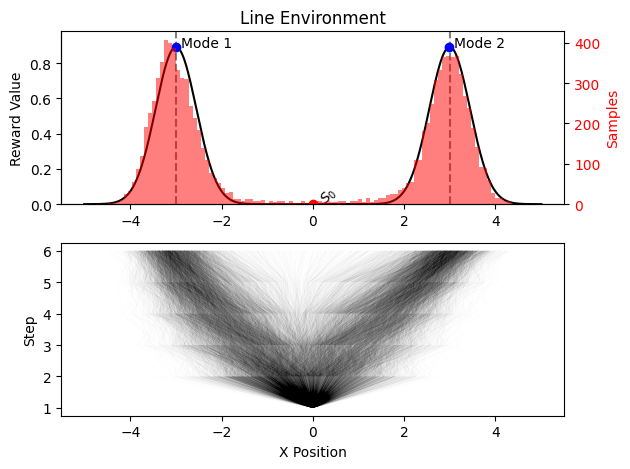

In [ ]:
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

# A Too Hard Example?

Looks good! Let's try something more complex...

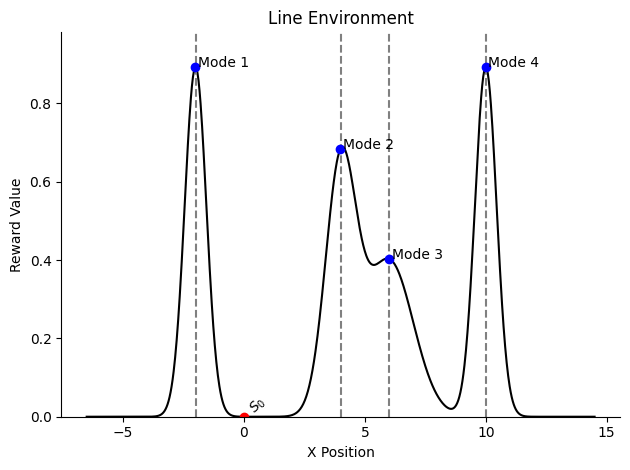

In [ ]:
env = LineEnvironment(
    mus=[-2, 4, 6, 10],
    variances=[0.2, 0.4, 1, 0.2],
    n_sd=4.5,
    init_value=0
)
render(env)

Here, we have 4 modes, and our starting point $S_0$ is now closest to Mode 1, and the different modes have different reward values. Let's train for 10k iterations to help the model out:

In [ ]:
init_exploration_noise = 2
trajectory_length = 5
n_iterations = 10_000
min_policy_std = 0.1
max_policy_std = 1.0

forward_model, backward_model, logZ = train_with_exploration(
    seed,
    batch_size,
    trajectory_length,
    env,
    device,
    init_exploration_noise,
    n_iterations=n_iterations,
)

Training iter 9900: (loss=1.849, estimated logZ=0.955, true logZ=1.386, LR=0.001, off policy noise=0.0198): 100%|██████████| 10000/10000 [02:52<00:00, 57.88it/s]


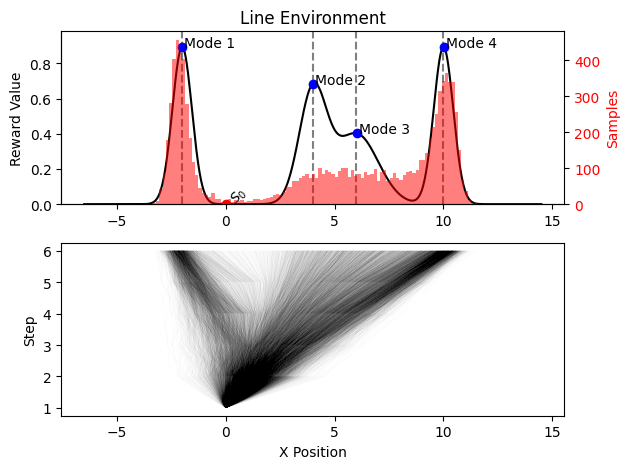

In [ ]:
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

Things aren't looking good yet. The model has learned to x positions reliabily in the highest reward regions, but it isn't modelling mode 2 and 3 well yet, so we are nowhere close to sampling from the correct probability distribution.

We can get decent results with more compute: `trajectory_lengths=10` and `n_iterations=50_000`, but we don't have time to train this during the tutorial. Try playing with this notebook at home to build an intution as to how the different hyperparameters affect the results:

+ `trajectory_length`
+ `init_exploration_noise`
+ `min/max_policy_std`
+ `n_iterations`
+ `learning_rate` (for the model and logZ estimate seperately!)
+ `hid_dim`

A key takeaway here is that the complexity of tuning the hyperparameters for training a continuous GFlowNet quickly grows with the complexity of the environment... even in a very simple case such as this one.

# Harder (and More Realistic) Examples in the `GFlowNet` Library

For a more interesting example, please see [the Continuous Cube Environment](https://github.com/alexhernandezgarcia/gflownet/blob/main/gflownet/envs/cube.py#L286) from [`GFlowNet`](https://github.com/alexhernandezgarcia/gflownet/tree/main), a GFlowNet training framework designed by a group of researchers at Mila (including a few of this workshop's instructors: Alex Hernandez-Garcia, Michał Koziarski, Victor Schmidt, and Alexandra Volokhova).

For installation, see [here](https://github.com/alexhernandezgarcia/gflownet/tree/main) and see the configuration file [here](https://github.com/alexhernandezgarcia/gflownet/tree/main/config/experiments/ccube) to train the task on your machine. This environment implements multiple important complexities we have so far ignored:

+ The environment allows for early termination by including a [Bernoulli in the action space](https://github.com/alexhernandezgarcia/gflownet/blob/96f1eaf44e1200bd45ec4a6a5a8a5acca8ff0111/gflownet/envs/cube.py#L360) which represents the probability of exiting.
+ The action space is governed by Beta distribution (i.e., with support on $(0, 1)$) with a scale parameter.
+ Forward and backward actions are [governed by different distributions](https://github.com/alexhernandezgarcia/gflownet/blob/96f1eaf44e1200bd45ec4a6a5a8a5acca8ff0111/gflownet/envs/cube.py#L593). This is important: in general, forward and backward actions **are not the same** when defining Continuous GFlowNets.
+ The log probability calculations with a mixture of dsitributions becomes [complicated very quickly](https://github.com/alexhernandezgarcia/gflownet/blob/96f1eaf44e1200bd45ec4a6a5a8a5acca8ff0111/gflownet/envs/cube.py#L940), especially if the calculation is step-dependent.

This is only scratching the surface, but I hope it is clear from glancing at this implementation how Continuous GFlowNets quickly become challenging to handle, so using them for non-toy applications should be done with careful consideration. There is still a lot of research to be done on improving their ease-of-use!

# A Self Contained Example of the SImple 1D Environment

For your convienience, we've copied all relevant logic from the above here, so you can play with the hyperparameters etc. to see how this affects training of the Continuous GFlowNet. **For this to work, please remember to run the imports and helper function cells at the beginning of the notebook!**

<ipython-input-10-392bb2024412>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)
Training iter 9900: (loss=0.430, estimated logZ=0.519, true logZ=0.693, LR=0.001, off policy noise=0.0198): 100%|██████████| 10000/10000 [02:46<00:00, 60.20it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary =

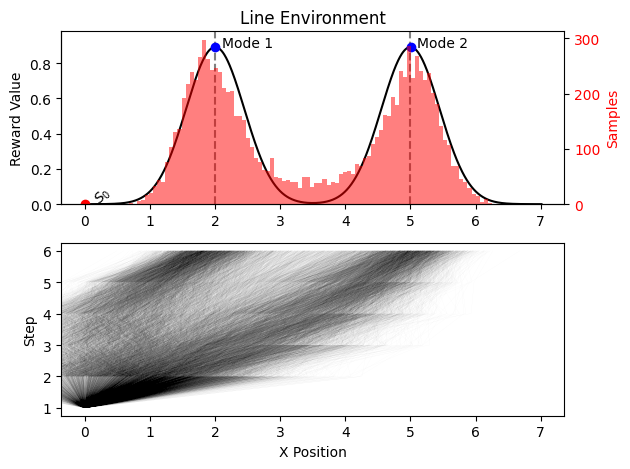

In [ ]:
class LineEnvironment():
    def __init__(self, mus, variances, n_sd, init_value):
        self.mus = torch.tensor(mus)
        self.sigmas = torch.tensor([math.sqrt(v) for v in variances])
        self.variances = torch.tensor(variances)
        self.mixture = [
            Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)
        ]

        self.n_sd = n_sd
        self.lb = min(self.mus) - self.n_sd * max(self.sigmas)  # Convienience only.
        self.ub = max(self.mus) + self.n_sd * max(self.sigmas)  # Convienience only.

        self.init_value = init_value  # Used for s0.
        assert self.lb < self.init_value < self.ub

    def log_reward(self, x):
        """Sum of the exponential of each log probability in the mixture."""
        return torch.logsumexp(torch.stack([m.log_prob(x) for m in self.mixture], 0), 0)

    @property
    def log_partition(self) -> float:
        """Log Partition is the log of the number of gaussians."""
        return torch.tensor(len(self.mus)).log()


def setup_experiment(hid_dim=64, lr_model=1e-3, lr_logz=1e-1):
    """Generate the learned parameters and optimizer for an experiment.

    Forward and backward models are MLPs with a single hidden layer. logZ is
    a single parameter. Note that we give logZ a higher learning rate, which is
    a common trick used when utilizing Trajectory Balance.
    """
    # Input = [x_position, n_steps], Output = [mus, standard_deviations].
    forward_model = torch.nn.Sequential(torch.nn.Linear(2, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, 2)).to(device)

    backward_model = torch.nn.Sequential(torch.nn.Linear(2, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, 2)).to(device)

    logZ = torch.nn.Parameter(torch.tensor(0.0, device=device))

    optimizer = torch.optim.Adam(
        [
            {'params': forward_model.parameters(), 'lr': lr_model},
            {'params': backward_model.parameters(), 'lr': lr_model},
            {'params': [logZ], 'lr': lr_logz},
        ]
    )

    return (forward_model, backward_model, logZ, optimizer)


def step(x, action):
    """Takes a forward step in the environment."""
    new_x = torch.zeros_like(x)
    new_x[:, 0] = x[:, 0] + action  # Add action delta.
    new_x[:, 1] = x[:, 1] + 1  # Increment step counter.

    return new_x


def initalize_state(batch_size, device, env, randn=False):
    """Trajectory starts at state = (X_0, t=0)."""
    x = torch.zeros((batch_size, 2), device=device)
    x[:, 0] = env.init_value

    return x


def get_policy_and_exploration_dist(model, x, off_policy_noise):
    """
    A policy is a distribution we predict the parameters of using a neural network,
    which we then sample from.
    """
    pf_params = model(x)
    policy_mean = pf_params[:, 0]
    policy_std = torch.sigmoid(pf_params[:, 1]) * (max_policy_std - min_policy_std) + min_policy_std
    policy_dist = torch.distributions.Normal(policy_mean, policy_std)

    # Add some off-policy exploration.
    exploration_dist = torch.distributions.Normal(policy_mean, policy_std + off_policy_noise)

    return policy_dist, exploration_dist


def inference(trajectory_length, forward_model, env, batch_size=10_000):
    """Sample some trajectories."""
    with torch.no_grad():
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        trajectory[:, 0, 0] = env.init_value

        x = initalize_state(batch_size, device, env)

        for t in range(trajectory_length):
            policy_dist, _ = get_policy_and_exploration_dist(forward_model, x, 0)
            action = policy_dist.sample()

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

    return trajectory


def train_with_exploration(
        seed,
        batch_size,
        trajectory_length,
        env,
        device,
        init_explortation_noise,
        n_iterations=10_000
    ):
    """Continuous GFlowNet training loop, with exploration, and the Trajectory Balance objective."""
    seed_all(seed)
    forward_model, backward_model, logZ, optimizer = setup_experiment()   # Default hyperparameters used.
    losses = []
    tbar = trange(n_iterations)
    true_logZ = env.log_partition

    exploration_schedule = np.linspace(init_explortation_noise, 0,  n_iterations)

    for iteration in tbar:
        optimizer.zero_grad()

        x = initalize_state(batch_size, device, env)

        # Trajectory stores all of the states in the forward loop.
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        logPF = torch.zeros((batch_size,), device=device)
        logPB = torch.zeros((batch_size,), device=device)

        # Forward loop to generate full trajectory and compute logPF.
        for t in range(trajectory_length):

            policy_dist, exploration_dist = get_policy_and_exploration_dist(
                forward_model,
                x,
                exploration_schedule[iteration],
            )
            action = exploration_dist.sample()
            logPF += policy_dist.log_prob(action)

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

        # Backward loop to compute logPB from existing trajectory under the backward policy.
        # Note this range skips S_1 -> S_0 -- we assign this action automatically p=1,
        # or log probability 0, which we don't need to explictly accumulate to logPB.
        for t in range(trajectory_length, 1, -1):
            policy_dist, _ = get_policy_and_exploration_dist(
                backward_model,
                trajectory[:, t, :],
                1,  # Exploration dist isn't used.
            )
            action = trajectory[:, t, 0] - trajectory[:, t - 1, 0]
            logPB += policy_dist.log_prob(action)
            print(t)

        log_reward = env.log_reward(trajectory[:, -1, 0])  # Reward from the final state.

        # Compute Trajectory Balance Loss.
        loss = (logZ + logPF - logPB - log_reward).pow(2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if iteration % 100 == 0:
            tbar.set_description("Training iter {}: (loss={:.3f}, estimated logZ={:.3f}, true logZ={:.3f}, LR={}, off policy noise={:.4f})".format(
                iteration,
                np.array(losses[-100:]).mean(),
                logZ.item(),
                true_logZ,
                optimizer.param_groups[0]['lr'],
                exploration_schedule[iteration],
                )
            )

    return (forward_model, backward_model, logZ)


# Hyperparameters.
batch_size = 256
init_exploration_noise = 2
max_policy_std = 1.0
min_policy_std = 0.1
n_iterations = 10_000
seed = 4444
trajectory_length = 5

# Define Environment.
env = LineEnvironment(
    mus=[2, 5],
    variances=[0.2, 0.2],
    n_sd=4.5,
    init_value=0
)

# Train.
forward_model, backward_model, logZ = train_with_exploration(
    seed,
    batch_size,
    trajectory_length,
    env,
    device,
    init_exploration_noise,
    n_iterations=n_iterations,
)

# Plot Results.
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)
